In [1]:
from backtesting import Backtest, Strategy
import talib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

np.random.seed(42)

df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']]= df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

def add_features(data):
    """Use existing features and add additional ones for ML model"""
    df = data.copy()
    
    # Use the existing indicators (MA5, MA10, MA20, Volatility, Momentum)
    # and create additional features from them
    
    # Normalized price distances from MAs
    df['X_MA5'] = (df.Close - df.MA5) / df.Close
    df['X_MA10'] = (df.Close - df.MA10) / df.Close
    df['X_MA20'] = (df.Close - df.MA20) / df.Close
    
    # MA crossovers
    df['X_MA5_10'] = (df.MA5 - df.MA10) / df.Close
    df['X_MA10_20'] = (df.MA10 - df.MA20) / df.Close
    
    # Use existing Volatility and Momentum
    df['X_Volatility'] = df.Volatility
    df['X_Momentum'] = df.Momentum
    
    # Relative return features
    df['X_Return'] = df.Return
    df['X_Return_5'] = df.Return.rolling(5).sum()
    
    # Volume features
    df['X_VOL_CHG'] = df.Volume.pct_change(5)
    
    # Convert to our desired format if it's not already binary
    df['Target_orig'] = df.Target
    df['Target'] = np.where(df.Return.shift(-1) > 0.005, 1,    # Long if >0.5% up
                    np.where(df.Return.shift(-1) < -0.005, -1,  # Short if >0.5% down
                    0))                                         # No position if in between
    
    return df.dropna()

def get_X(data):
    """Return feature matrix X"""
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    """Return target variable y"""
    y = data.Target.values
    return np.where(y == -1, 0, np.where(y == 0, 1, 2))

# Apply features
df = add_features(df)
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [5]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestStrategy(Strategy):
    n_estimators = 100
    price_delta = 0.01
    lookback_window = 200  # Dynamic training window size

    def init(self):
        # Feature + label prep
        full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
        self.all_data = full_df.loc[self.data.df.index.intersection(full_df.index)]
        
        # Extract features
        self.features = [col for col in self.all_data.columns if col.startswith("X_")]
        
        # Initialize model
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=5,
            min_samples_split=10,
            random_state=42
        )
        
        # Prediction tracking
        self.predictions = []
        self.actuals = []

    def next(self):
        # Current position in the backtest
        current_idx = len(self.data) - 1
        
        # Safety check - make sure we have enough data
        if current_idx < self.lookback_window:
            return
            
        # Get current data index
        current_candle_time = self.data.index[-1]
        
        try:
            # Find corresponding index in our all_data DataFrame
            idx_in_all_data = self.all_data.index.get_indexer([current_candle_time])[0]
            
            # Check if valid index found
            if idx_in_all_data < 0 or idx_in_all_data < self.lookback_window:
                return
                
            # Safe slicing with loc instead of iloc
            start_idx = self.all_data.index[idx_in_all_data - self.lookback_window + 1]
            end_idx = self.all_data.index[idx_in_all_data]
            train_data = self.all_data.loc[start_idx:end_idx].iloc[:-1]  # All but last point
            test_data = self.all_data.loc[end_idx:end_idx]  # Just the last point
            
            # Check if we have enough data
            if len(train_data) < self.lookback_window // 2:
                return
                
            # Extract features and target
            X_train = train_data[self.features].values
            y_train = train_data["Target"].values
            X_test = test_data[self.features].values
            y_true = test_data["Target"].values[0]
            
            # Train model dynamically on each call
            self.model.fit(X_train, y_train)
            
            # Make prediction
            prediction = self.model.predict(X_test)[0]
                
            # Log predictions and labels
            if prediction in [-1, 0, 1]:
                self.predictions.append(prediction)
                self.actuals.append(int(y_true))
                
            # Trade execution with take-profit and stop-loss
            close = self.data.Close[-1]
            tp_long = close * (1 + self.price_delta)
            sl_long = close * (1 - self.price_delta)
            tp_short = close * (1 - self.price_delta)
            sl_short = close * (1 + self.price_delta)
            
            # Trading logic
            if prediction == 1:
                if not self.position.is_long:
                    self.position.close()
                    self.buy(tp=tp_long, sl=sl_long)
                    
            elif prediction == -1:
                if not self.position.is_short:
                    self.position.close()
                    self.sell(tp=tp_short, sl=sl_short)
                    
            # Risk management with trailing stop
            for trade in self.trades:
                if self.data.index[-1] - trade.entry_time > pd.Timedelta(days=5):
                    if trade.is_long:
                        trade.sl = max(trade.sl, trade.entry_price)
                    else:
                        trade.sl = min(trade.sl, trade.entry_price)
                        
        except (IndexError, KeyError) as e:
            # Handle exceptions gracefully to avoid breaking the backtest
            pass

In [6]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("📈 Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [7]:
bt = Backtest(df, RandomForestStrategy, cash=10_000, commission=.0002, margin=0.05)
backtest = bt.run()
backtest

/var/folders/bg/6x82p8q55dxf8pb_c34j03mm0000gn/T/ipykernel_37202/2896026881.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')


Backtest.run:   0%|          | 0/981 [00:00<?, ?bar/s]

/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=518: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=519: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=520: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=521: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954: UserWarning: time=523: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:954:

Start                     2020-02-06 00:00:00
End                       2023-12-29 00:00:00
Duration                   1422 days 00:00:00
Exposure Time [%]                    16.70061
Equity Final [$]                    170.43461
Equity Peak [$]                   14497.77494
Commissions [$]                    4220.57778
Return [%]                          -98.29565
Buy & Hold Return [%]                42.56257
Return (Ann.) [%]                   -64.82907
Volatility (Ann.) [%]                39.14054
CAGR [%]                            -51.40348
Sharpe Ratio                         -1.65632
Sortino Ratio                        -0.92442
Calmar Ratio                           -0.656
Alpha [%]                          -126.23921
Beta                                  0.65653
Max. Drawdown [%]                   -98.82441
Avg. Drawdown [%]                   -44.85675
Max. Drawdown Duration      841 days 00:00:00
Avg. Drawdown Duration      277 days 00:00:00
# Trades                          

📈 Evaluation Metrics
Accuracy: 0.4311
Precision (macro): 0.3959
F1 Score (macro): 0.3897


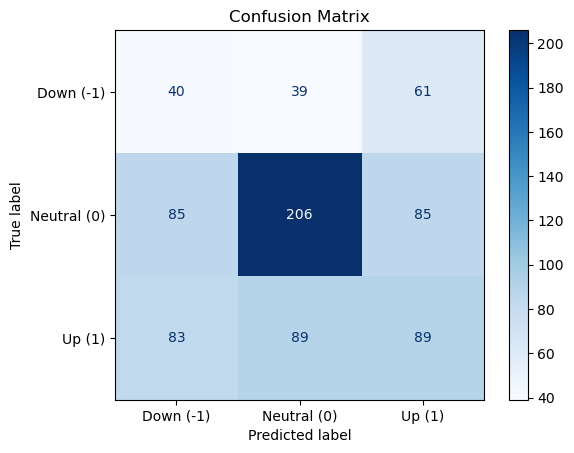

In [8]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)

In [9]:
bt.plot()

GridPlot(id='p1327', ...)